In [1]:
import os, sys, re
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# импорт collections для работы с упорядоченным словарём
from collections import OrderedDict

# повышение разрешения для графики
# sns.set(rc={'figure.dpi':600, 'savefig.dpi':600})
# установка стиля matplotlib
%matplotlib inline
# plt.style.use('ggplot')

# доступные стили отображения графика в matplotlib
# plt.style.available

# библиотека иерархической кластеризации (для построения дендрограммы) 
# from scipy.cluster import hierarchy

# библиотека для построения выпуклой оболочки множества точек 
# from scipy import spatial

# from ydata_profiling import ProfileReport         # отключено пока не "починят"
# import sweetviz as sv
# import dtale
# import statistics as stcs
# import statsmodels.stats.proportion as stsmdls

# библиотека для расчетов корреляций
# from scipy import stats
from sklearn import metrics

# библиотека для нормализации, стандартизации
from sklearn import preprocessing

# библиотека модели линейной регрессии
from sklearn import linear_model

# библиотека модели деревьев решения
# from sklearn import tree

# библиотека модели ансамблей
# from sklearn import ensemble

# библиотека модели кластеризации
# from sklearn import cluster

# библиотека модели эллиптической кластеризации
# from sklearn import mixture

# библиотека модели метода главных компонент PCA
# from sklearn import decomposition

# библиотека модели TSNE
# from sklearn import manifold

# библиотека clustergram-кластеризации
# from clustergram import Clustergram

# библиотека для разделения датасета
from sklearn import model_selection

# библиотека для исключения признаков RFE
# from sklearn import feature_selection

# библиотека для кодирования признаков
# import category_encoders as ce

# для обработки timestamp в формате utc
import datetime, time

# работа с json
# import json
from pprint import pprint

# веб-скрэпинг сайтов
# import requests
# from bs4 import BeautifulSoup

# выводить все результаты вычислений в ячейках Code
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# подключить Latex
from IPython.display import Latex

# загрузка файлов
import wget
# import kaggle

# логгирование / логирование
import logging

# скрытие сообщений об ошибках при обработке ответов
import warnings
# игнорируем предупреждения
warnings.filterwarnings('ignore')

# библиотека для передачи функции обратного вызова
# from functools import partial

# библиотека поиска гиперпараметров hyperopt
# import hyperopt
# from hyperopt import hp, fmin, tpe, Trials

# библиотека поиска гиперпараметров optuna
import optuna
from optuna import Trial, study, samplers

# изменить формат вывода pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.set_option('display.max_info_rows', 500)
# pd.set_option('display.max_info_columns', 500)
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.large_repr', 'truncate')

In [2]:
# КОНСТАНТЫ
# делитель для констант (для более быстрых расчётов)
DIVIDER = 2

# фиксация генерации воспроизведения
RANDOM_SEED = 42

# число фолдов кросс-валидации
CV_FOLDS = 5

# число ядер для расчётов моделей
CPU = -1

# число итераций Optuna
N_TRIALS = int(100 / DIVIDER)

# упорядоченный "прототип" словаря для сохранения результатов
total_res = OrderedDict([
    ('Модель', []),
    ('Гиперпараметры модели', []), 
    ('Полиномизация', []), 
    ('MAPE train', []), 
    ('MAPE test', [])
    ]
)

In [3]:
# создаём объект класса как estimator
def get_estimator_linear(
        model_type:linear_model.LinearRegression | linear_model.Lasso | \
        linear_model.Ridge | linear_model.ElasticNet, 
        
        **params:dict | None
    ) -> linear_model.LinearRegression | linear_model.Lasso | \
        linear_model.Ridge | linear_model.ElasticNet:
    """ Функция генерации объекта класса:   линейная регрессия, регрессия с L1-, L2- или смешанной регуляризацией. 
                                            Если словарь пустой - создаётся модель с параметрами по умолчанию.

    Args:
        model_type (str):   текстовое сокращённое наименование модели.

                            'linear' - модель линейной регрессии, 

                            'lasso' - модель линейной регрессии с L1-регуляризацией, 

                            'ridge' - модель линейной регрессии с L2-регуляризацией, 
                            
                            'elastic' - модель линейной регрессии со смешанной регуляризацией
        
        params (dict | None):   внешний словарь параметров модели | значение None (пустой словарь). 
                                При значении None генерируется стандартный объект класса 
                                + заданные параметры в params_estimator_

    Returns:
        estimator_ (
            linear_model.LinearRegression | 
            
            linear_model.Lasso | 
        
            linear_model.Ridge | 
            
            linear_model.ElasticNet:    объект класса линейная регрессия (LinearRegression)
                                                    
                                        объект класса линейная регрессия с L1-регуляризацией (Lasso)
                                                    
                                        объект класса линейная регрессия с L2-регуляризацией (Ridge)
                                                    
                                        объект класса линейная регрессия со смешанной регуляризацией (ElasticNet)
    """
    
    # словарь парараметров модели
    params_estimator_ = {
        **params,                           # внешние параметры
        'random_state':RANDOM_SEED, 
    }

    match model_type:
        case 'linear':
            params_estimator_.pop('random_state')
            estimator_ = linear_model.LinearRegression(**params_estimator_)
        
        case 'lasso':
            estimator_ = linear_model.Lasso(**params_estimator_)
        
        case 'ridge':
            estimator_ = linear_model.Ridge(**params_estimator_)
        
        case 'elastic':
            estimator_ = linear_model.ElasticNet(**params_estimator_)
    
    return estimator_

# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Прочитаем исходные данные:

In [4]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


In [6]:
# создаём список числовых признаков (они все числовые)
features = list(data.columns)
features

['Well', 'Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod']

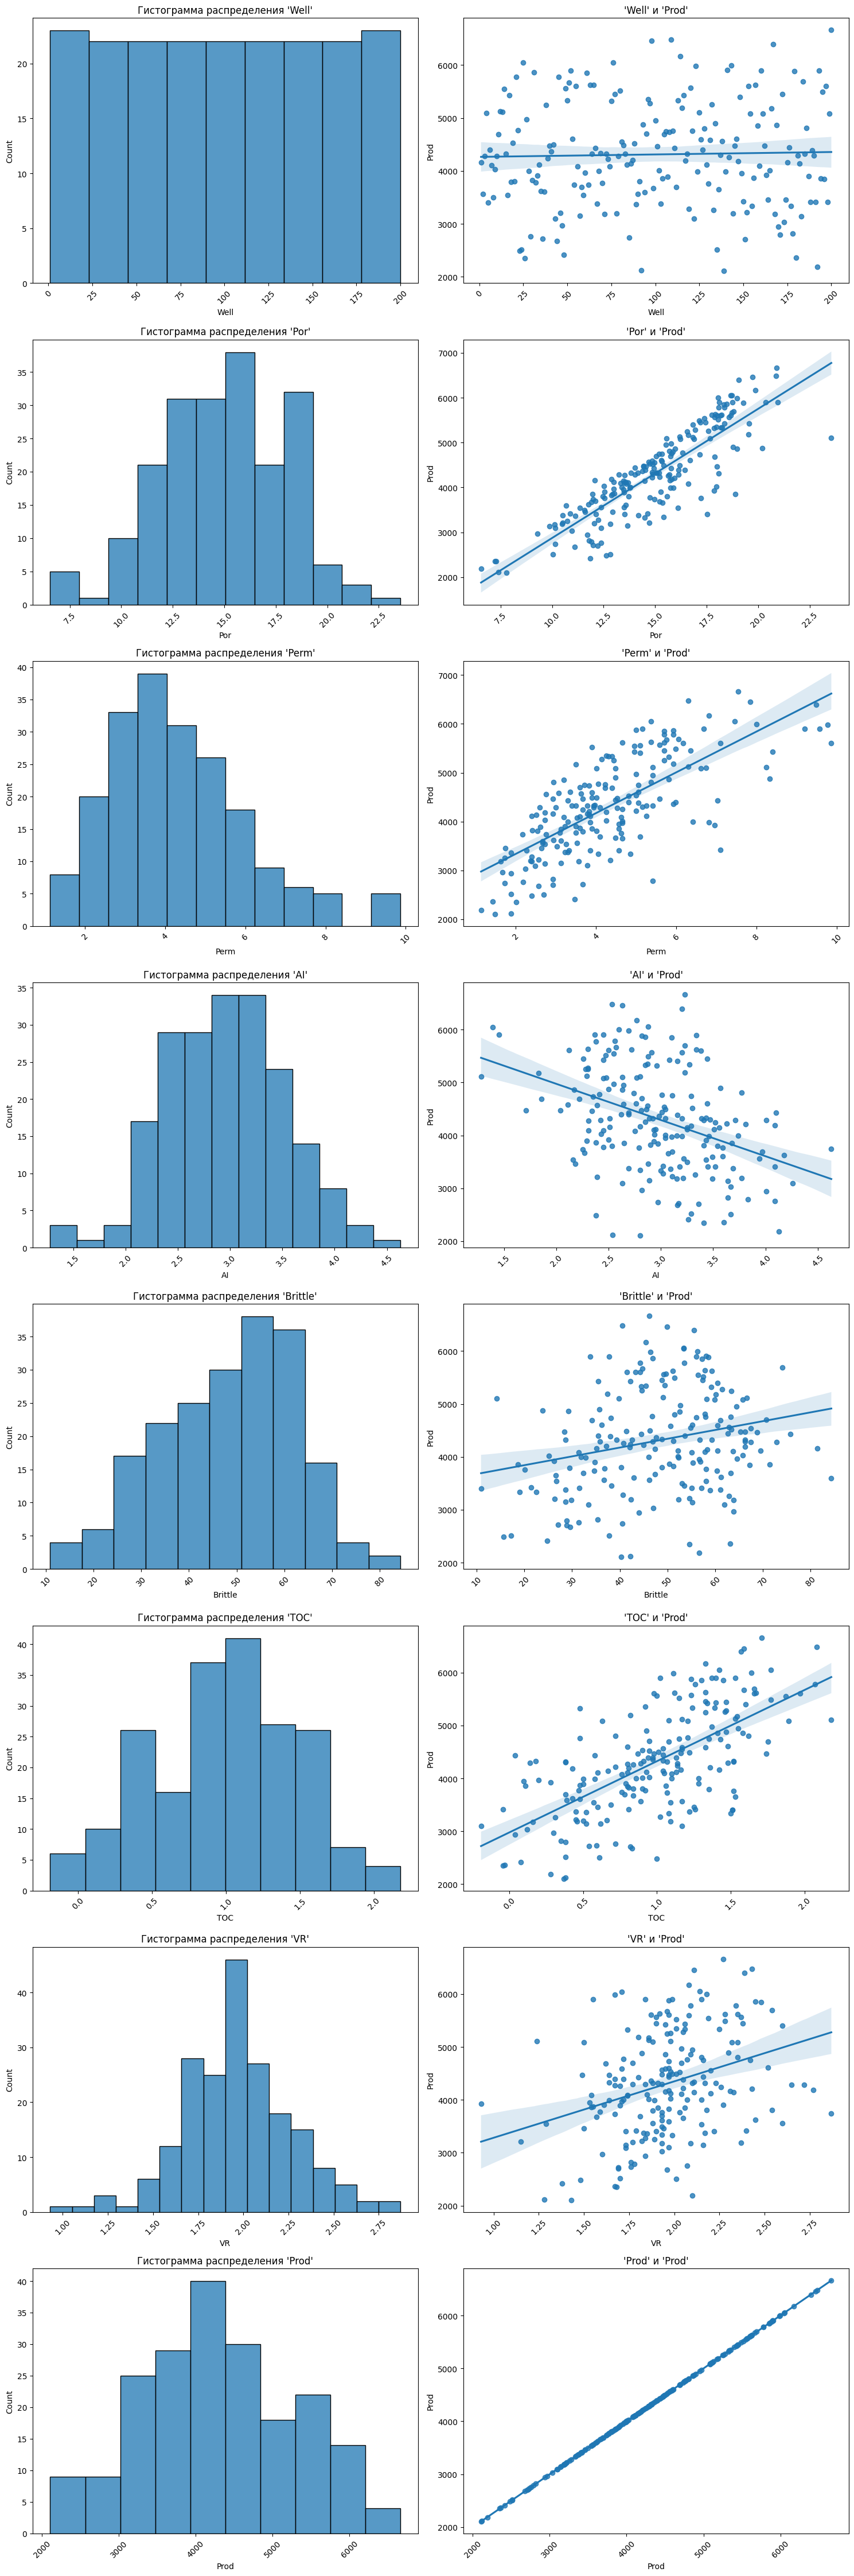

In [7]:
# количество числовых признаков
n = len(features)

# фигура + n*2 координатных плоскостей
fig, axes = plt.subplots(n, 2, figsize=(15, 45))

# создаём цикл для всех признаков из списка
# i - индекс, feature - название признака в списке
for i, feature in enumerate(features): 
    # строим гистограмму распределения признака
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    
    # добавляем подпись графику гистограммы
    histplot.set_title(f"Гистограмма распределения '{feature}'")
    
    # поворот меток на оси абсцисс на 45 градусов
    histplot.xaxis.set_tick_params(rotation=45)
    
    # строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data, x=feature, y='Prod', ax=axes[i][1])
    
    # добавляем подпись графику графику рассеяния
    regplot.set_title(f"'{feature}' и 'Prod'")
    
    # добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)

# выравнивание графиков
plt.tight_layout();

#### **Выводы:**

1. Распределение данных, в основном, близко к нормальному. Исключение - равномерное для 'Well'. Как вариант, предложу что - от 'Well' мало что будет зависеть и от него впоследствии можно будет избавиться, т.к. характер горизонтальной "средней" говорит именно об этом.
2. Целевая переменная имеет обратную зависимость от признака AI, в остальных случаях - прямая зависимость.

---

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [8]:
# центрирование значений
A_cent = data - data.mean()

# нормирование значений
A_st = A_cent/np.linalg.norm(A_cent, axis=0)

# матрица Грама стандартизованных значений (матрица корреляций)
C = A_st.T @ A_st
C

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
Por,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
Perm,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
AI,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
Brittle,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
TOC,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
VR,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
Prod,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


In [9]:
# вывод тепловой карты
def plot_heatmap(
        data_:pd.DataFrame=data,
        figsize_:tuple=(10, 10)
    ) -> None:
    """ Функция вывода тепловой карты, заданного размера

    Args:
        data_ (pd.DataFrame, optional): датафрейм данных длоя построения графика. 
                                        Defaults to data.
        
        figsize_ (tuple): размеры координатной сетки. Defaults to (10, 10).
    """
    
    # полотно для построения графика
    plt.figure(figsize=figsize_)

    # строим тепловую карту матрицы корреляций
    ax_heat_ = sns.heatmap(
        data=data_, 
        annot=True, 
        fmt='.3f', 
        cmap='coolwarm', 
        square=True, 
        linewidth=0.05, 
        # linecolor='gray', 
        vmin=-1, 
        vmax=1,
        mask=np.triu(np.ones_like(data_)),  # срезовая маска, вывод параметров по нижней диагонали
    )

    # задаём заголовок
    ax_heat_.set(title='Тепловая карта матрицы корреляций');

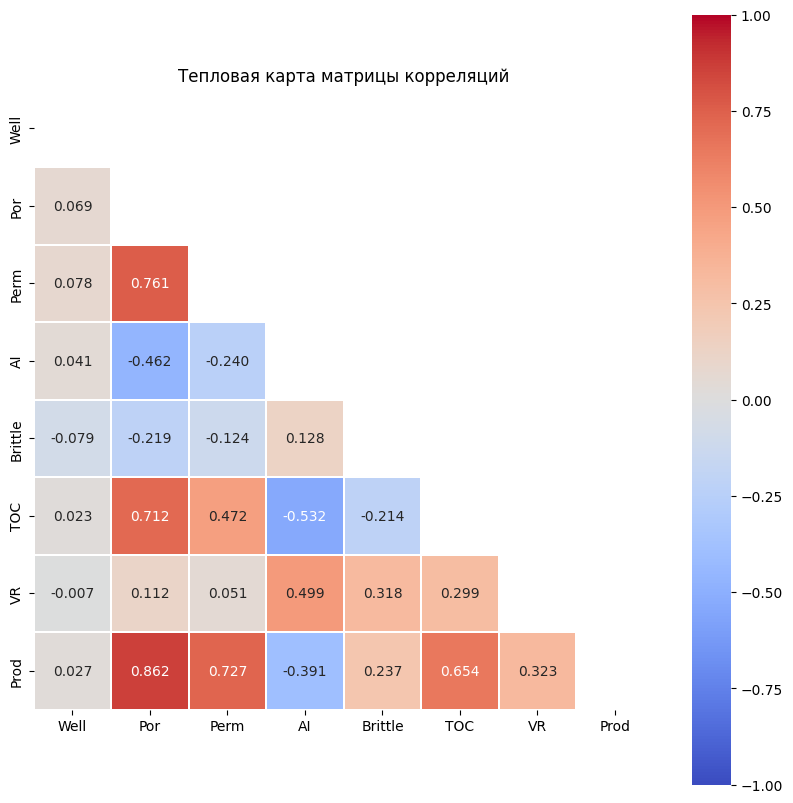

In [10]:
# выводим тепловую карту
plot_heatmap(C)

In [11]:
# топ-3 коррелирующих факторов
C['Prod'].apply(lambda x: abs(x)).sort_values(ascending=False)[1:4]

Por     0.861910
Perm    0.727426
TOC     0.654445
Name: Prod, dtype: float64

In [12]:
print(f'Ранг матрицы корреляций: {np.linalg.matrix_rank(C)}')

Ранг матрицы корреляций: 8


In [13]:
print(f'Определитель матрицы корреляций: {np.linalg.det(C).__round__(5)}')

Определитель матрицы корреляций: 0.00073


#### **Выводы:**

1. Корреляционная матрица плохо обусловлена. Текущая матрица близка к вырожденной, её определитель близок к нулю. Соответственно, данные являются плохо обусловленными.

2. Присутствует корелляция между признаками в виде средней и сильной связи. Коэффициент корреляции между целевой переменной ***Prod*** и признаками *Por*, *Perm* и *TOC* составляет 0.86, 0.73 и 0.65, соответственно, что даёт понимание о наличии мультиколлинеарности.

3. Модель классической линейной регрессии по методу наименьших квадратов применима, данные отнормированы, но мультиколлинеарность усложняет интерпретацию параметров линейной регрессии.

---

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [14]:
# создаём матрицу наблюдений X и вектор целевой переменной y
def get_w_hat(
    data_:pd.DataFrame=data
    ) -> np.ndarray | pd.DataFrame | pd.Series:
    """ Функция, вычисляющая коэффициенты по МНК

    Args:
        data_ (pd.DataFrame): датафрейм для вычисления коэффициентов линейной регрессии. Defaults to data.

    Returns:
        w_hat_ (np.ndarray): вектор коэффициентов МНК линейной регрессии
        
        w_hat_df_ (pd.DataFrame): датафрейм МНК коэффициентов линейной регрессии

        X_ (np.ndarray): матрица значений признаков с единичным столбцом

        y_ (pd.Series): вектор целевых значений
    """
    X_ = np.column_stack((
        np.ones(data_.shape[0]), 
        data_.iloc[:, :-1].values
        )
    )
    y_ = data_['Prod']

    # вычисляем OLS-оценку для коэффициентов без стандартизации
    w_hat_ = np.linalg.inv(X_.T@X_) @ X_.T@y_

    # составляем датафрейм из признаков и округленных коэффициентов
    w_hat_df_ = pd.DataFrame(
        data=np.round(w_hat_, 0), 
        index=np.hstack((
            ['Intercept'], 
            np.array(data.columns[:-1])
            )
        ),
        columns = ['Coefficients']
    )
    return w_hat_, w_hat_df_, X_, y_

In [15]:
# сохраняем результат функции в переменные:
# вектор коэффициентов МНК линейной регрессии, его версия в виде датафрейма, 
# матрица наблюдений X и вектор правильных ответов y
w_hat, w_hat_df, X, y = get_w_hat(data)
w_hat
w_hat_df

array([-1.23230803e+03,  5.07003631e-02,  2.30179140e+02,  1.16239006e+02,
       -3.65202301e+02,  2.49943700e+01, -7.84009294e+01,  7.85259815e+02])

,Coefficients
Intercept,-1232.0
Well,0.0
Por,230.0
Perm,116.0
AI,-365.0
Brittle,25.0
TOC,-78.0
VR,785.0


#### **Выводы:**

1. К неинформативным признакам относится коэффициент отвечающий за идентификатор скважины - *Well*, т.к. его значение составляет сотые доли единиц, поэтому, практически, никак не влияет на вычисления по сравнению с другими признаками.

2. Имеются коэфициенты с положительными и отрицательными значениями. Коэффициенты *AI* и *TOC* оказывают обратное влияние назначение целевой переменной, случае увеличения значения таких значений - мы получим прогноз уменьшения выработки в скважине.

3. Больше всего влияет признак *Por* в сторону увеличения и признак *AI* в сторону уменьшения.

---

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [16]:
# прогнозируемые значения
x_new = np.array([1, 106, 15.32, 3.71, 3.29, 55.99, 1.35, 2.42])
y_new = 4748.315024

# прогнозное значение выработки
y_new_pred_new = np.round(x_new@w_hat, 5)
print(f'Прогноз выработки газа, фут^3/день: {y_new_pred_new}')
print (f'Абсолютная ошибка выработки газа, фут^3/день: {np.round(np.abs(y_new - y_new_pred_new), 5)}')

Прогноз выработки газа, фут^3/день: 4723.06405
Абсолютная ошибка выработки газа, фут^3/день: 25.25097


In [17]:
# вычисляем метрику модели
y_pred = X@w_hat
print(f'MAPE модели: {(metrics.mean_absolute_percentage_error(y, y_pred)*100):.2f} %')

MAPE модели: 3.63 %


#### **Выводы:**

С учётом того, что в построенной модели включены все факторы (в т.ч. мультиколлинеарные), MAPE в 3.6 % можно назвать, весьма, низким, можно предварительно и с осторожностью говорить о том, что модель справляется очень хорошо. Но следует держать в памяти, что модель построена на плохо обусловленных данных, и может оказаться как хорошей, так и "плохой", когда значения могут "поплыть в другие степи" и оказаться впоследствии нерепрезентативными.

---

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

,Coefficients
Well,0.0
Por,230.0
Perm,116.0
AI,-365.0
Brittle,25.0
TOC,-78.0
VR,785.0


Well       0.026817
Por        0.861910
Perm       0.727426
AI        -0.390835
Brittle    0.237155
TOC        0.654445
VR         0.323182
Name: Prod, dtype: float64

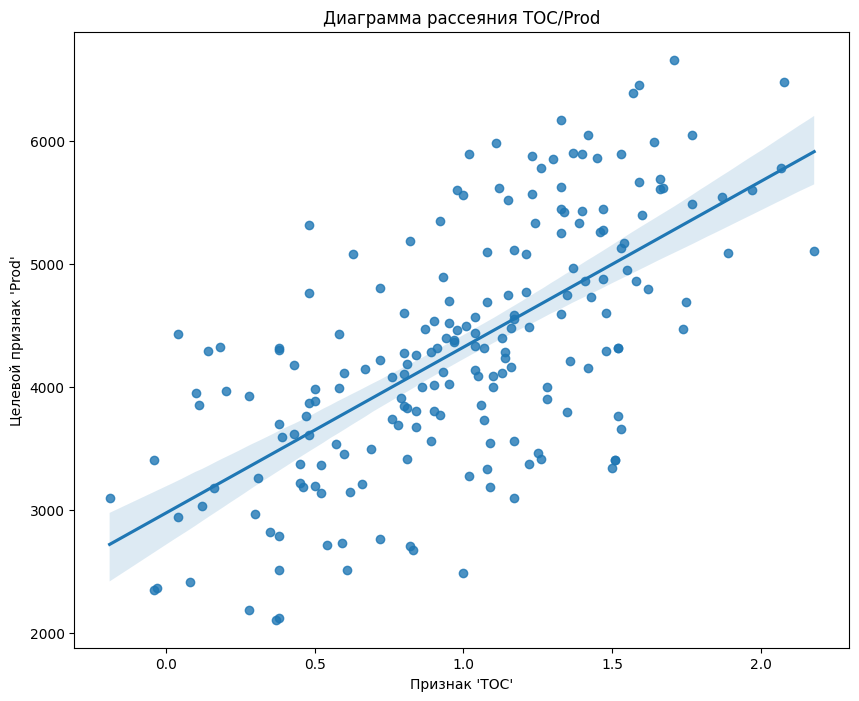

In [18]:
# вывод вектора МНК и матрицы корреляций для сравнения значений
display(w_hat_df[1:])
display(C['Prod'][:-1])

# полотно для построения графика
plt.subplots(figsize=(10, 8))

# диаграмма рассеяния + линейная регрессия
ax_regplot = sns.regplot(data=data, x='TOC', y='Prod')
ax_regplot.set(
    xlabel="Признак 'TOC'", 
    ylabel="Целевой признак 'Prod'", 
    title='Диаграмма рассеяния TOC/Prod'
);

#### **Выводы:**

1. График зависимости признака *TOC* от целевой переменной ***Prod*** показывает прямую и линейную зависимость между признаками, т.е с ростом одного признака, растет и другой.

2. Сравнивая коэффициенты, полученные по МНК с коэффициентами корреляционной матрицы, можно увидеть разницу в знаке у признака *TOC*, т.о. векторы *TOC* и ***Prod*** сонаправлены, исходя из положительного коэффициента корелляции между этими признаками.

3. Сравнивая коэффициент, полученный по МНК, видно, что он идёт со знаком "минус", в таком случае, прогнозируемая величина будет падать, в случае возрастания значения данного признака, что не совсем некорректно, в дальнейшем модель будет давать все бОльшую ошибку. Это может быть объяснено наличием сильной мультиколлинеарности в данных (сила связи больше 0.7), которая "деформирует" коэффициенты.

---

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

=======================================================================================

Из матрицы корреляций следует, что наиболее сильно связаны между собой факторы *Por* - *Perm* и *Por* - *TOC*. Исключаем *Perm* и *TOC*, оставляем *Por*, имеющий наибольший коэффициент корреляции с целевой переменной, также удаляем фактор *Well*, т.к. корреляция с целевой переменной  ~**0.05**.

In [19]:
# обновляем исходный датасет
drop_columns = ['Perm', 'TOC', 'Well']
data.drop(columns=drop_columns, axis=1, inplace=True)

In [20]:
# вычислем обновлённые показатели / массивы
w_hat_new, w_hat_df_new, X_new, _ = get_w_hat(data)
w_hat_new
w_hat_df_new

array([-1835.44646069,   293.03624565,  -200.03091206,    27.64098209,
         517.40272597])

,Coefficients
Intercept,-1835.0
Por,293.0
AI,-200.0
Brittle,28.0
VR,517.0


In [21]:
# предсказание на всем датасете с новыми коэффициентами
y_pred_new = X_new@w_hat_new
print(f'MAPE модели: {(metrics.mean_absolute_percentage_error(y, y_pred_new)*100):.2f} %')

# сравниваем коэффициенты вектора линейной регрессии и матрицы корреляций
w_hat_df_new[1:]
data.corr()['Prod'][:-1]

MAPE модели: 4.04 %


,Coefficients
Por,293.0
AI,-200.0
Brittle,28.0
VR,517.0


Por        0.861910
AI        -0.390835
Brittle    0.237155
VR         0.323182
Name: Prod, dtype: float64

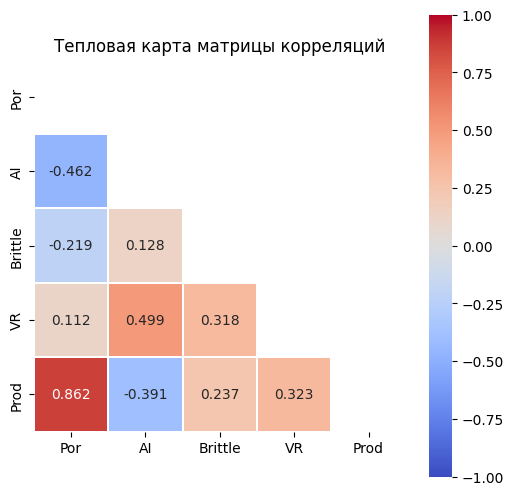

In [22]:
# выводим тепловую карту
plot_heatmap(data.corr(), (6, 6))

In [23]:
print(f'Определитель матрицы корреляций: {np.linalg.det(np.corrcoef(X_new[:, 1:].T)).__round__(5)}')

Определитель матрицы корреляций: 0.36826


#### **Выводы:**

1. Удаление сильнокореллированных признаков помогло избавится от некорректного "поведения" модели, коэффициенты корреляции и вектор коэффициентов по МНК пришли в соответствие и "синхронизовались" по знаку.

2. В связи с удалением признаков незначительно ухушилась метрика, но всё также осталась, весьма низкой, повышение составило 11.3 %, сложно судить много это или мало, я бы сказал, примлемо.

3. Изменились коэффициенты вектора линейной регрессии, по сравнению с моделью, обученной на всех признаках:

| Признак | Коэффицент, исходная модель | Коэффицент, улучшенная модель |
| :---: | :---: | :---: |
| Por | 230 | 293 |
| AI | -365 | -200 |
| Brittle | 25 | 28 |
| VR | 785 | 517 |

Можно сказать, что они "стабилизировались" и явно стали ближе к 0, как бы, "подтянулись" к 0.

4. В дополнение, определитель матрицы с меньшим количеством признаков увеличился, что говорит об улучшении модели в направлении "стабилизации" прогнозирования результата.

---

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [24]:
# создаём модель линейной регрессии
LR = linear_model.LinearRegression(fit_intercept=False)

# обучаем модель
LR.fit(X_new, y)

# собираем коэффициенты линейной регрессии в датафрейм
w_hat_df_lr = pd.DataFrame(
    data=np.round(LR.coef_, 0), 
    index=np.hstack((
            ['Intercept'], 
            np.array(data.columns[:-1])
            )
        ),
        columns = ['Coefficients']
    )

# смотрим результат
w_hat_df_lr

# делаем предсказание
y_new_pred_new_lr = LR.predict(X_new)

print(f'MAPE модели: {(metrics.mean_absolute_percentage_error(y, y_new_pred_new_lr)*100):.2f} %')

LinearRegression(fit_intercept=False)

,Coefficients
Intercept,-1835.0
Por,293.0
AI,-200.0
Brittle,28.0
VR,517.0


MAPE модели: 4.04 %


#### **Выводы:**

Как видно из результата, коэффициенты, полученные в результате обучения модели **LinearRegression** из библиотеки ***scikit-learn***, полностью идентичны значениям коэффициентов, полученных путём применения матричной формулы с помощью NumPy.

Т.о. можно сделать вывод, что алгоритм *scikit-learn.LinearRegression* построен на тех же правилах, что и аналитический метод наименьших квадратов.

---

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [25]:
# инициализируем стандартизатор StandardScaler
SS_scaler = preprocessing.StandardScaler()

# подгоняем параметры стандартизатора на данных без единичного столбца
X_scaled = SS_scaler.fit_transform(X_new[:, 1:])

# добавляем полиномиальные признаки
PF = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
X_poly = PF.fit_transform(X_scaled)

print(f'Количество полиномиальных признаков: {X_poly.shape[1]}')

Количество полиномиальных признаков: 34


In [26]:
# вывод метрик модели и сохранение метрик модели в словарь
def get_model_metrics(
    estimator_:linear_model.LinearRegression | linear_model.Lasso | \
        linear_model.Ridge | linear_model.ElasticNet, 

    hyperparams:dict='Без подбора гиперпараметров', 
    poly_features:str='Да', 
    cv_:int | None=CV_FOLDS, 
    X_train_:pd.DataFrame=X_poly, 
    y_train_:pd.Series=y, 
    
) -> None:
    """ Функция вывода метрик, сохранения метрик в упорядоченный словарь

    Args:
        estimator_ (str): модель для расчёта метрик.

        hyperparams (dict): словарь подобранных наилучших гиперпараметров estimator_. Defaults to None.

        poly_features (str): признак стандартизации и полиномизации признаков, строковое значение. Defaults to 'Да'
        
        cv_ (int | None, optional): число фолдов кросс-валидации модели. Defaults to CV_FOLDS.
        
        X_train_ (pd.DataFrame, optional):  тренировочный датасет, содержит стандартизованные 
                                            полиномальные признаки. Defaults to X_poly.
        
        y_train_ (pd.Series, optional): тренировочный вектор целевых значений. Defaults to y.
    """
    
    # оцениваем качество модели на кросс-валидации, метрика — MAPE
    cv_results = model_selection.cross_validate(
        estimator_, 
        X_train_, y_train_, 
        scoring='neg_mean_absolute_percentage_error', 
        cv=cv_, 
        return_train_score=True
    )

    cv_train = cv_results['train_score'].mean() * 100
    cv_test = cv_results['test_score'].mean() * 100

    # вывод метрик
    print(f"MAPE на тренировочных фолдах: {-cv_train:.2f} %")
    print(f"MAPE на валидационных фолдах: {-cv_test:.2f} %")

    # записываем в OrderedDict результаты метрик модели
    total_res['Модель'].append(estimator_.__class__.__name__)
    total_res['Гиперпараметры модели'].append(hyperparams)
    total_res['Полиномизация'].append(poly_features)
    total_res['MAPE train'].append(round(-cv_train, 2))
    total_res['MAPE test'].append(round(-cv_test, 2))

Так как у нас ранее была построена модель линейной регрессии без стандартизации и полиномизации коэффициентов, то было бы интересно посмотреть на метрики этой модели в сравнении с моделями, которые используют "подготовленные" для расчётов данные. Посмотрим и сохраним данные в словарь:

In [27]:
# расчёт метрик модели без стандартизации и полиномизации исходных признаков
get_model_metrics(
    LR, 
    poly_features='Нет', 
    X_train_=X_new, 
    y_train_=y
)

MAPE на тренировочных фолдах: 4.02 %
MAPE на валидационных фолдах: 4.23 %


In [28]:
# расчёт метрик модели простой линейной регрессии
get_model_metrics(
    get_estimator_linear('linear'), 
)

MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.68 %


#### **Выводы:**

1. Линейная регрессия представляет собой прямую, проведенную через все наблюдения, таким образом, чтобы ошибка отклонения от среднего была минимальна. Применение полинома позволяет построить кривую, результат - отклонение от среднего становится меньше, и, как следствие, улучшается предсказание.

2. Применение полиномиальной регрессии с 3-мя признаками и кросс-валидации по 5-ти фолдам позволило <font color='LightSeaGreen'>**существенно повысить**</font> показатели метрики MAPE - почти `в 2.3 раза (~2.27) на тренировочной выборке` и почти `на 60 % (~57.84 %) на валидационной выборке`.

3. Переход к стандартизованным полиномиальным коэффициентам <font color='LightSeaGreen'>**значительно улучшил модель**</font> и нивелировал перетренированность модели.

---

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [29]:
def optuna_linear(
        trial:optuna.Trial, 
        model_type_:str
    ) -> float | np.ndarray:
    """ Функция, обучающая модель по имеющимся гиперпараметрам набора.

    Args:
        trial (optuna.Trial): класс вызова гиперпараметров библиотеки optuna
        
        model_type_ (str): строковое обозначение оптимизируемой модели

    Returns:
        score (float | np.ndarray): метрика | массив метрик
    """

    # общий для всех моделей словарь подбора гиперпараметра alpha
    params_alpha = {
        'alpha': Trial.suggest_float(trial, 'alpha', 1, 10, step=0.5)
    }

    # в зависимости от названия модели создаём объект класса с заданными параметрами
    if model_type_ == 'lasso':
            model_ = get_estimator_linear(model_type_, **params_alpha)
    

    if model_type_ == 'ridge':
            model_ = get_estimator_linear(model_type_, **params_alpha)


    if model_type_ == 'elastic':
        # словарь подбора гиперпараметров alpha + l1_ratio
        params_elastic = {
            **params_alpha,
            'l1_ratio': Trial.suggest_float(trial, 'l1_ratio', 0.1, 1, step=0.05)
        }
        
        model_ = get_estimator_linear(model_type_, **params_elastic)

    # расчёт метрики модели на кросс-валидации
    score = model_selection.cross_val_score(
        model_, 
        X_poly, y, 
        scoring='neg_mean_absolute_percentage_error', 
        cv=CV_FOLDS
        ).mean()

    return abs(score)

In [30]:
def optuna_study_optimize(
        model_:str, 
        n_trials_:int=N_TRIALS
    ) -> optuna.study:
    """ Функция для поиска гиперпараметров, заданной модели

    Args:
        model (_type_): строковое обозначение модели, для которой проводится оптимизация
        
        n_trials (int, optional): число попыток поиска гиперпараметров. Defaults to N_TRIALS.

    Returns:
        _type_: Результат поиска гиперпараметров
    """

    # cоздаем объект исследования для набора гиперпараметров, 
    # записываем локально в базу SQLite, при наличии базы - дозапись в неё
    optuna_study = study.create_study(
        storage='sqlite:///db/optuna.db',
        study_name=model_, 
        direction="minimize",
        load_if_exists=True
    )
    
    # задаём модель исследования
    optuna_trial = lambda trial: optuna_linear(trial, model_)

    # задаём уровень логирования (без вывода "полотна" в консоль)
    optuna.logging.set_verbosity(optuna.logging.ERROR)

    # ищем лучшую комбинацию гиперпараметров n_trials раз
    optuna_study.optimize(
        optuna_trial, 
        n_trials=n_trials_, 
        show_progress_bar=True,     # выводим результаты со шкалой прогресса
        n_jobs=CPU
    )
    
    return optuna_study

In [31]:
# проверяем статус логирования
print(optuna.logging.get_verbosity())

20


In [32]:
study_Lasso = optuna_study_optimize('lasso')
print(f'Наилучшие значения гиперпараметров {study_Lasso.best_params}')

[I 2023-05-30 15:41:15,279] A new study created in RDB with name: lasso


  0%|          | 0/50 [00:00<?, ?it/s]

Наилучшие значения гиперпараметров {'alpha': 5.0}


In [33]:
# расчёт метрик модели Lasso
get_model_metrics(
    get_estimator_linear('lasso', **study_Lasso.best_params), 
    study_Lasso.best_params
)

MAPE на тренировочных фолдах: 1.83 %
MAPE на валидационных фолдах: 2.28 %


#### **Выводы:**

1. Обучение модели проводилось на стандартизированных данных с полиномизацией коэффициентов признаков.

2. Для подбора гиперпараметров применена библиотека Optuna. Функции поиска и оптимизации гиперпараметров универсальны для всех линейных регрессий проекта.

3. По модели **Lasso** <font color='LightSeaGreen'>**прирост**</font> по метрике MAPE на валидационной выборке составил более 15 % (~17.54 %), что весьма, неплохо. На тренировочной выборке метрика MAPE незначительно скорректировалась на -3 % (~ -3,4 %). <font color='LightSeaGreen'>**Модель ещё немного улучшена.**</font>

4. В качестве поиска оптимального гиперпараметра был использован только $\alpha$ (*alpha*), полученные результаты найденного параметра дают понимание, что он оптимален, если будет больше в 5 раз относительно стандартного значения ($\alpha = 1$).

---

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [34]:
study_Ridge = optuna_study_optimize('ridge')
print(f'Наилучшие значения гиперпараметров {study_Ridge.best_params}')

  0%|          | 0/50 [00:00<?, ?it/s]

Наилучшие значения гиперпараметров {'alpha': 1.0}


In [35]:
# расчёт метрик модели Ridge
get_model_metrics(
    get_estimator_linear('ridge', **study_Ridge.best_params), 
    study_Ridge.best_params
)

MAPE на тренировочных фолдах: 1.83 %
MAPE на валидационных фолдах: 2.72 %


#### **Выводы:**

1. По модели **Ridge** прироста по метрикам MAPE на тренировочных выборках не произошло, более того, выявился некоторый <font color='Tomato'>**"откат"**</font> на валидационной выборке, на почти 20 % (~19.3 %). Данные цифры говорят, как минимум, о <font color='Tomato'>**неверно подобранном алгоритме модели или требуемых иных сочетаний других параметров**</font>, таких как:

    * *solver* - численный метод поиска решения, 
    
    * *max_iter* - число итераций, 
    
    * *tol* - точность вычислений,

    и другие.

2. В качестве поиска оптимального гиперпараметра был использован только $\alpha$ (*alpha*), полученные результаты найденного параметра дают понимание, что он уже оптимально подобран, поскольку подбор других параметров не выполнялся по заданию, они также были связаны с параметром $\alpha$ (*alpha*) и, взаимно, $\alpha$ (*alpha*) был связан с остальными параметрами модели **Ridge**. Отсюда его и "константность".

---

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [36]:
study_Elastic = optuna_study_optimize('elastic')
print(f'Наилучшие значения гиперпараметров {study_Elastic.best_params}')

  0%|          | 0/50 [00:00<?, ?it/s]

Наилучшие значения гиперпараметров {'alpha': 5.0, 'l1_ratio': 1.0}


In [37]:
# расчёт метрик модели ElasticNet
get_model_metrics(
    get_estimator_linear('elastic', **study_Elastic.best_params), 
    study_Elastic.best_params
)

MAPE на тренировочных фолдах: 1.83 %
MAPE на валидационных фолдах: 2.28 %


In [38]:
# понаблюдаем переход от модели ElasticNet -> Lasso
Elastic = get_estimator_linear('elastic', **study_Elastic.best_params)
Elastic.fit(X_poly, y)

# присутствует много "занулённых" коэффициентов
Elastic.intercept_
with np.printoptions(precision=3, suppress=True):
    print(Elastic.coef_)

ElasticNet(alpha=5.0, l1_ratio=1.0, random_state=42)

4380.301966759578

[ 927.204  -88.22   375.123  121.023   70.464    0.       8.122    0.
   -3.043   -1.56    -0.856 -136.274    0.      -0.       2.764  -15.03
    4.156    5.497    0.      -0.      -0.     -71.691   -0.       0.
   -0.       5.365    0.       0.       0.      -6.414  -19.313    0.
    5.274    0.   ]


#### **Выводы:**

1. По модели **ElasticNet** выявлен прирост по обеим метрикам MAPE, метрики MAPE вышли на тот же уровень как и с моделью **Lasso**, не уступая ей. Вполне ожидаемо, т.к. **ElasticNet** использует обе регуляризации.

2. В качестве оптимальных гиперпараметров подобраны значения:

    * $\alpha$ (*alpha*) увеличен в 5 раз,

    * $\lambda$ (*l1_ratio*) без изменений.

3. Модель **ElasticNet**"перешла" в **Lasso**, в чистом виде:

    * $\lambda$ (*l1_ratio*) = 1

    * 15 из 34 полиномиальных коэффициентов обнулились в результате поиска оптимальных гиперпараметров, 

    * метрики MAPE на обеих выборках абсолютно идентичны метрикам MAPE с моделью **Lasso**.

---

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [39]:
# сформируем из OrderedDict датафрейм
pd.DataFrame(total_res)

,Модель,Гиперпараметры модели,Полиномизация,MAPE train,MAPE test
0,LinearRegression,Без подбора гиперпараметров,Нет,4.02,4.23
1,LinearRegression,Без подбора гиперпараметров,Да,1.77,2.68
2,Lasso,{'alpha': 5.0},Да,1.83,2.28
3,Ridge,{'alpha': 1.0},Да,1.83,2.72
4,ElasticNet,"{'alpha': 5.0, 'l1_ratio': 1.0}",Да,1.83,2.28


#### **Выводы:**

1. Модель без преобразования признаков простой линейной регрессии **LinearRegression** имеет самые худшие показатели предсказания, последнее место.

2. Модель с $L_2$-регуляризацией - **Ridge**, хоть и на порядок лучше модели **LinearRegression** (численные методы, точность расчётов алгоритма и другие преимущества данной модели), но все же, достаточно, отстает от модели линейной регрессии с $L_1$-регуляризацией - **Lasso**. Третье место.

3. Модель линейной регрессии с добавлением полиномиальных признаков, почти идеально, метрики показывают, что перетренированность модели достаточно хорошо нивелирована, очень хорошо, но не отлично. Второе место, по праву.

4. Первое место заняли модели:

    * модель линейной регрессии с добавлением $L_1$-регуляризации - **Lasso**,

    * модель линейной регрессии смешанного типа, с "гибридной" регуляризацией - **ElasticNet**. 

    Результаты один-в-один совпадают, что не удивительно, т.к. "эластичный" алгоритм работает на смешении двух типов регуляризации, $L_1$- и $L_2$-, процесс оптимизации "трансформировал" **ElasticNet** → **Lasso**, о чем указывает:
    
    * подобранный параметр $\lambda$ (*l1_ratio*) = 1,

    * подобранный параметр $\alpha$ (*alpha*) = 5, совпадает у обеих моделей.

    * 15 из 34 полиномиальных коэффициентов обнулились в результате поиска оптимальных гиперпараметров, 

---

# **Общий вывод по проекту:**

1. Применение полиномиальных признаков значительно и существенно улучшают предсказательную модель.

2. Правильно подобранный тип регуляризации и его параметров, улучшают предсказательную модель, "уводят" модель от перетреннированности.

3. Предсказание данных в текущей задаче идеально решаются линейной регрессией с полиномиальными коэффициентами и $L_1$-регуляризацией - **Lasso** или **ElasticNet** с $L_1$-регуляризацией.